We bring in StrategyAgent (ideas), RiskAgent (filters), and add our new AllocatorAgent (decision maker).

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np

from strategy_agent import StrategyAgent
from risk_agent import RiskAgent


AllocatorAgent takes approved strategies (from RiskAgent).

It can apply different allocation rules:

Equal-weighting (simple)

Sharpe-weighting (give more to higher Sharpe)

It outputs portfolio weights and final returns.

In [2]:
class AllocatorAgent:
    def __init__(self, method="equal"):
        self.method = method
    
    def allocate(self, strategies: dict, metrics: dict, risk_assessments: dict):
        # Filter only strategies that passed RiskAgent
        approved = {
            name: df for name, df in strategies.items()
            if risk_assessments[name]["Decision"] == "PASS"
        }
        approved_metrics = {
            name: metrics[name] for name in approved.keys()
        }
        
        if not approved:
            return None, "No strategies passed risk checks"
        
        if self.method == "equal":
            weights = {name: 1/len(approved) for name in approved}
        
        elif self.method == "sharpe":
            sharpes = {name: m["Sharpe"] for name, m in approved_metrics.items()}
            total = sum(sharpes.values())
            weights = {name: s/total for name, s in sharpes.items()}
        
        # Build portfolio
        portfolio = pd.DataFrame(index=list(approved.values())[0].index)
        for name, df in approved.items():
            portfolio[name] = df["Strategy_Return"] * weights[name]
        portfolio["Portfolio_Return"] = portfolio.sum(axis=1)
        portfolio["Cumulative"] = (1 + portfolio["Portfolio_Return"]).cumprod()
        
        return weights, portfolio


Now the three agents work together:

StrategyAgent runs SMA, RSI, Bollinger.

RiskAgent evaluates metrics.

AllocatorAgent assigns weights and builds portfolio.

Weights: {'Bollinger': np.float64(1.0)}


<Axes: title={'center': 'Allocator Portfolio Curve'}, xlabel='Price'>

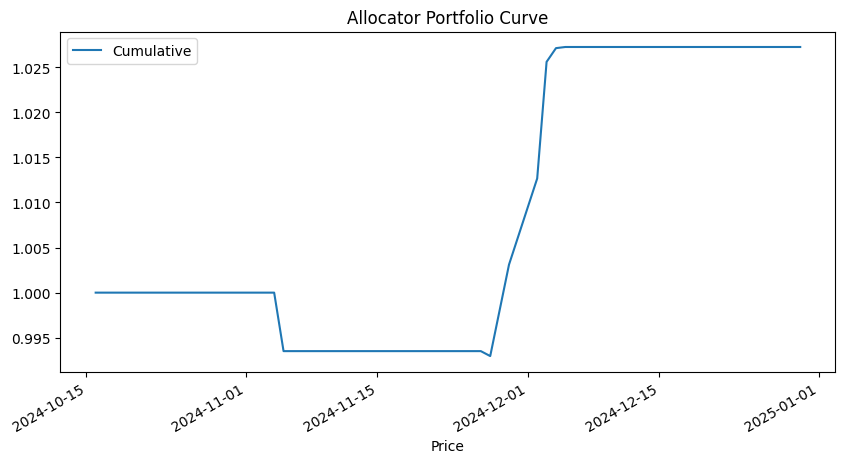

In [3]:
# Load data
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)

# Step 1: Strategies
strategy_agent = StrategyAgent(data)
strategies = {
    "SMA": strategy_agent.sma_crossover(),
    "RSI": strategy_agent.rsi_strategy(),
    "Bollinger": strategy_agent.bollinger_breakout()
}

# Step 2: Metrics
def compute_metrics(df):
    strat_curve = (1 + df["Strategy_Return"]).cumprod()
    years = (df.index[-1] - df.index[0]).days / 365.25
    cagr = strat_curve.iloc[-1]**(1/years) - 1
    vol = df["Strategy_Return"].std() * np.sqrt(252)
    sharpe = (df["Strategy_Return"].mean() * 252) / (df["Strategy_Return"].std() * np.sqrt(252))
    roll_max = strat_curve.cummax()
    dd = (strat_curve / roll_max - 1).min()
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}

metrics = {name: compute_metrics(df) for name, df in strategies.items()}

# Step 3: Risk check
risk_agent = RiskAgent(sharpe_min=1.0, max_dd=-0.25, vol_max=0.3)
risk_assessments = {name: risk_agent.assess(m) for name, m in metrics.items()}

# Step 4: Allocation
allocator = AllocatorAgent(method="sharpe")
weights, portfolio = allocator.allocate(strategies, metrics, risk_assessments)

print("Weights:", weights)
portfolio[["Cumulative"]].plot(title="Allocator Portfolio Curve", figsize=(10,5))


Save weights + portfolio returns so the audit trail shows not just strategy metrics, but also how the Allocator decided.

In [5]:
import os
from datetime import datetime

os.makedirs("../logs", exist_ok=True)

pd.DataFrame([weights]).to_csv("../logs/Day14_allocations.csv", index=False)
portfolio.to_csv("../logs/Day14_portfolio.csv")

with open("../logs/Day14_summary.txt", "w") as f:
    f.write(f"Day 14 run ({datetime.today().date()})\n")
    f.write("Weights:\n")
    f.write(str(weights) + "\n")


In [6]:
with open("../src/allocator_agent.py", "w") as f:
    f.write("""import pandas as pd

class AllocatorAgent:
    def __init__(self, method="equal"):
        self.method = method
    
    def allocate(self, strategies: dict, metrics: dict, risk_assessments: dict):
        approved = {name: df for name, df in strategies.items()
                    if risk_assessments[name]["Decision"] == "PASS"}
        approved_metrics = {name: metrics[name] for name in approved.keys()}
        
        if not approved:
            return None, "No strategies passed risk checks"
        
        if self.method == "equal":
            weights = {name: 1/len(approved) for name in approved}
        elif self.method == "sharpe":
            sharpes = {name: m["Sharpe"] for name, m in approved_metrics.items()}
            total = sum(sharpes.values())
            weights = {name: s/total for name, s in sharpes.items()}
        
        portfolio = pd.DataFrame(index=list(approved.values())[0].index)
        for name, df in approved.items():
            portfolio[name] = df["Strategy_Return"] * weights[name]
        portfolio["Portfolio_Return"] = portfolio.sum(axis=1)
        portfolio["Cumulative"] = (1 + portfolio["Portfolio_Return"]).cumprod()
        
        return weights, portfolio
""")
